In [1]:
# 导入相应的模块
# https://bigquant.com/wiki/doc/beta-ZB7T5faoog
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

[2021-06-29 10:46:56.997439] WARNING matplotlib.font_manager: Matplotlib is building the font cache; this may take a moment.


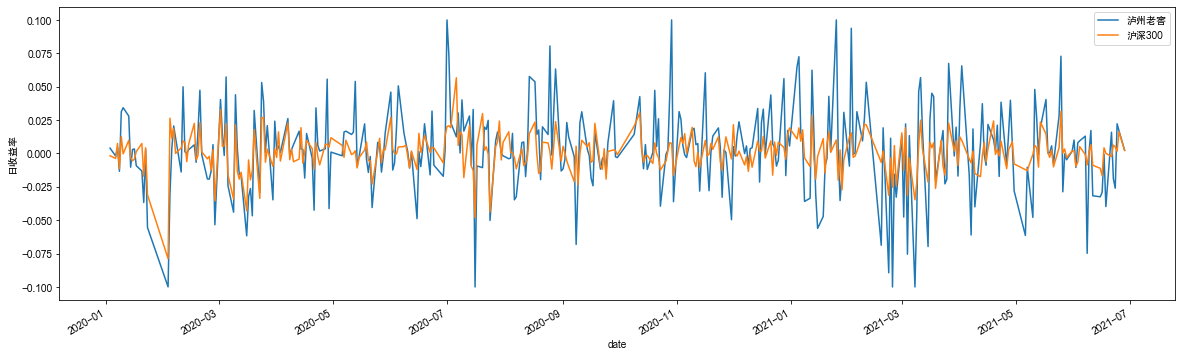

In [4]:
# 获取一段时间的股票数据
start_date = '2020-01-01'
end_date = '2021-06-29'
asset = D.history_data('000568.SZA',start_date,end_date,fields=['close']).set_index('date')['close']
benchmark = D.history_data('000300.SHA',start_date,end_date,fields=['close']).set_index('date')['close']
asset.name = '泸州老窖'
benchmark.name = '沪深300'

# 计算收益率
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# 绘制
r_a.plot(figsize=[20,6])
r_b.plot()
plt.ylabel("日收益率")
plt.legend();

现在我们可以通过回归求出 alpha($\alpha$) 和beta($\beta$)

In [6]:
X = r_b.values  
Y = r_a.values
x = sm.add_constant(X)
 
def linreg(x,y):
    # 增加一个常数项
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # 再把常数项去掉
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print('泸州老窖 alpha: ' + str(alpha))
print('泸州老窖 beta: ' + str(beta))

泸州老窖 alpha: 0.002253954452166821
泸州老窖 beta: 1.4768418417207985


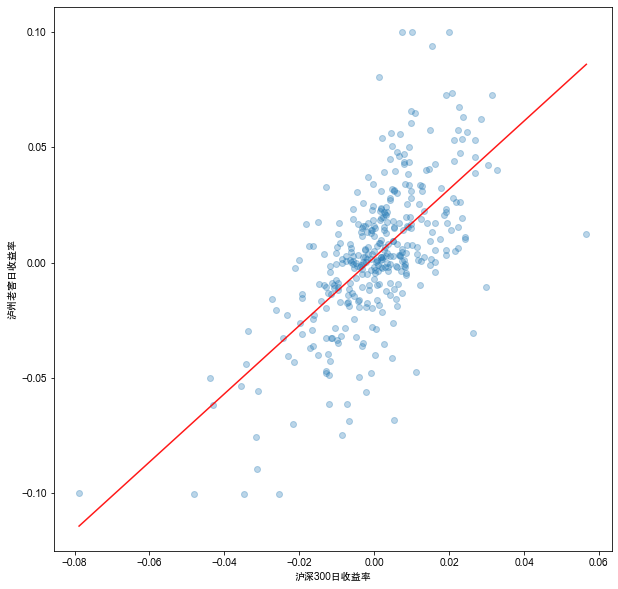

In [11]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.figure(figsize=(10, 10))
plt.scatter(X, Y, alpha=0.3) # 画出原始数据散点
plt.xlabel("沪深300日收益率")
plt.ylabel("泸州老窖日收益率")

 # 增加一条红色的回归直线
plt.plot(X2, Y_hat, 'r', alpha=0.9);


## 风险暴露

一般而言，beta描述的是持有资产所承担的 **系统风险**敞口这一概念，用$\beta$表示。 如果一项资产相对沪深300基准指数具有较高的$\beta$暴露水平，那么在市场上涨时，它的表现将会很好，当市场下跌时，它表现很差。 高$\beta$对应于高系统风险（高市场风险），意味着你的投资更具有波动性。

在BigQuant，我们重视尽可能没有系统风险暴露的 **市场中性**策略。 这意味着策略中的所有回报都在模型的$\alpha$部分，而与市场无关。 因为这意味着该策略与市场系统风险无关，不管是牛市还是熊市，它都具有稳定的业绩表现。 市场中性策略对于拥有大量现金池的机构（银行、保险、公募基金等）最具吸引力。

## 风险管理

减少因子风险暴露的过程称为 **风险管理**。对冲是在实践中进行风险管理的最佳方式之一。

通过案例来了解如何做到市场风险对冲的

现在我们已经知道要对冲多少市值，让我们看看它如何影响我们的收益。 我们使用贵州茅台和基准沪深300来构建我们的投资组合，将沪深300的权重设为-$\beta$（由于持有基准空头头寸）

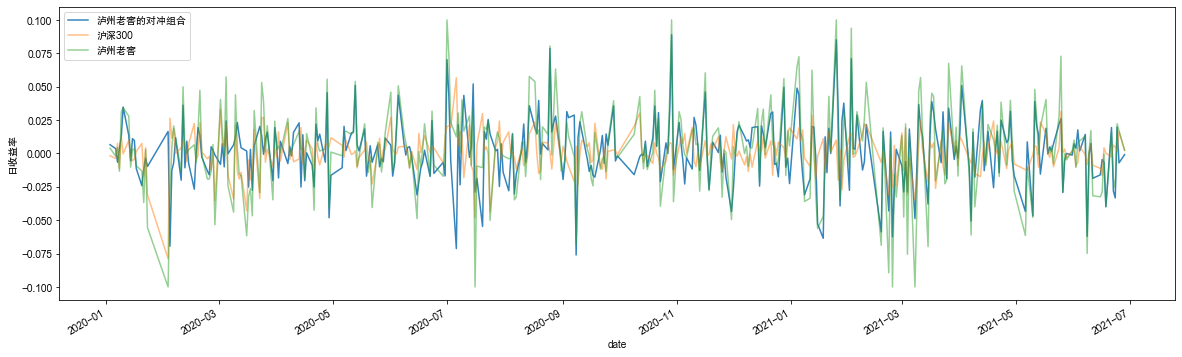

In [13]:
# 构建一个市场中性组合
portfolio = -1*beta*r_b + r_a
portfolio.name = "泸州老窖的对冲组合"

# 绘制各自的收益曲线
portfolio.plot(alpha=0.9,figsize=[20,6])
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("日收益率")
plt.legend();

看来组合（贵州茅台+沪深300）的收益和贵州茅台走势相当接近。 我们可以通过计算两者的平均回报率和风险（收益率的标准差）来量化其表现的差异

In [15]:
print("组合的平均回报率: ", portfolio.mean(), "泸州老窖的平均回报率: ", r_a.mean())
print("组合风险: ", portfolio.std(), "泸州老窖风险: ",r_a.std())

组合的平均回报率:  0.002253954065963626 泸州老窖的平均回报率:  0.003368095960468054
组合风险:  0.023845184594392776 泸州老窖风险:  0.031538721174001694


可以看出，我们以收益率为代价降低了波动，在降低风险的同时，收益也相应降低了。 接下来，我们来检查一下$\alpha$是否与以前一样，而$\beta$已被消除

In [16]:
P = portfolio.values
alpha, beta = linreg(X,P)
print('组合的alpha: ' + str(alpha))
print('组合的beta: ' + str(beta))  # alpha 和以前仍然一样 beta 已经被消除,beta几乎为0

组合的alpha: 0.0022539543728794303
组合的beta: 3.089436982129691e-08


请注意，我们使用历史数据构建了 **市场中性**策略。 我们可以通过在不同的时间框架内验证资产和对冲投资组合的$\alpha$和$\beta$值来检查其是否仍然有效

In [17]:
# 得到过去一年得到的alpha 和beta值
start_date = '2019-01-01'
end_date = '2020-01-01'
asset = D.history_data('000568.SZA',start_date,end_date,fields=['close']).set_index('date')['close']
benchmark = D.history_data('000300.SHA',start_date,end_date,fields=['close']).set_index('date')['close']
asset.name = '泸州老窖'
benchmark.name = '沪深300'
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
historical_alpha, historical_beta = linreg(X,Y)
print('泸州老窖过去一年得到的alpha 和beta值:')  # Asset Historical Estimate
print('alpha: ' + str(historical_alpha))
print('beta: ' + str(historical_beta))

# 获取下一年的数据:
start_date = '2020-01-01'
end_date = '2021-07-01'
asset = D.history_data('000568.SZA',start_date,end_date,fields=['close']).set_index('date')['close']
benchmark = D.history_data('000300.SHA',start_date,end_date,fields=['close']).set_index('date')['close']
asset.name = '泸州老窖'
benchmark.name = '沪深300'
# 重复前面的过程来计算alpha 和beta值
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print('泸州老窖次年的alpha 和beta值:')  # Asset Out of Sample Estimate
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

# 构建对冲投资组合来计算alpha、beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print('使用历史beta构建对冲组合的alpha 和beta值:')  # Portfolio Out of Sample
print ('alpha: ' + str(alpha))
print ('beta: ' + str(beta))

泸州老窖过去一年得到的alpha 和beta值:
alpha: 0.0018102102516168888
beta: 1.2888970830289899


泸州老窖次年的alpha 和beta值:
alpha: 0.002253954452166821
beta: 1.4768418417207985
使用历史beta构建对冲组合的alpha 和beta值:
alpha: 0.0022539544717877493
beta: 0.18794480725195642


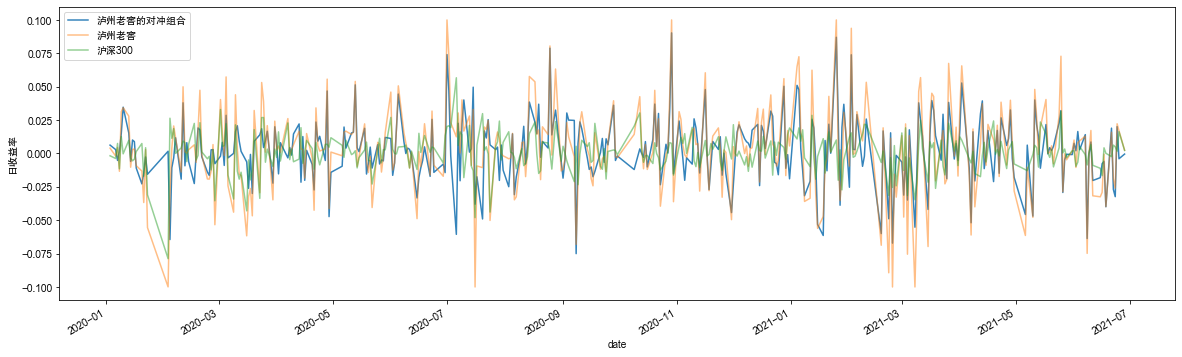

In [19]:
# 绘制图形
portfolio.name = "泸州老窖的对冲组合"
portfolio.plot(alpha=0.9,figsize=[20,6])
r_a.plot(alpha=0.5);
r_b.plot(alpha=0.5)
plt.ylabel("日收益率")
plt.legend();

In [20]:
# print("平均回报率: ", portfolio.mean(), r_a.mean())
# print("风险: ", portfolio.std(), r_a.std())

print("组合的平均回报率: ", portfolio.mean(), "泸州老窖的平均回报率: ", r_a.mean())
print("组合风险: ", portfolio.std(), "泸州老窖风险: ",r_a.std())

组合的平均回报率:  0.002395741641521454 泸州老窖的平均回报率:  0.003368095960468054
组合风险:  0.023989452049136162 泸州老窖风险:  0.031538721174001694


从上图可以看出，对冲后的收益降低了，但波动性也降低了。历史估计出的贝塔值在样本外的一年中是有效的，将资产的贝塔值0.673通过对冲降低到了0.193，也就是说降低了2/3，这样的对冲效果是比较明显的，而且也反映出历史的贝塔值是有效的，当然，要做到更好的效果，可以采取滚动估计贝塔的方法。